# Timescale Distribution Sweep Analysis

Analyze grid cell properties across different neural timescale distributions:
- **Discrete (1 value)**: Single timescale (α=0.5)
- **Discrete (2 values)**: Two timescales (α=0.25, 0.75)
- **Discrete (4 values)**: Four timescales (α=0.2, 0.4, 0.6, 0.8)
- **Power-law**: Continuous 1/f² distribution

Each distribution tested with both **ReLU** and **Tanh** activations (8 experiments total).

For each network we analyze:
1. Grid score distribution
2. Spatial frequency distribution (for grid cells)
3. Top 9 grid cell rate maps


In [ ]:
# === IMPORTS AND CONFIGURATION ===
import os
import yaml
import torch
import torch.nn as nn
import numpy as np
import matplotlib.pyplot as plt
from pathlib import Path

# Add parent directory to path for imports
import sys
sys.path.insert(0, str(Path.cwd().parent))

from timescales.rnns.multitimescale_rnn import MultiTimescaleRNN
from timescales.datamodules.path_integration import PathIntegrationDataModule
from timescales.analysis.spatial import SpatialAnalyzer

# === SWEEP CONFIGURATION ===
# Update this path after running the sweep



#DIR with no gradient pre-conditioning
#SWEEP_DIR = Path("/home/facosta/timescales/timescales/logs/experiments/timescale_distribution_sweep_20260122_043728")

#DIR with gradient pre-conditioning
SWEEP_DIR = Path("/home/facosta/timescales/timescales/logs/experiments/timescale_distribution_sweep_20260122_094217")



# Grid cell threshold
GRID_SCORE_THRESHOLD = 0.0

# Experiment names (must match sweep config)
EXPERIMENT_NAMES = [
    "ReLU_discrete_1",
    "ReLU_discrete_2", 
    "ReLU_discrete_4",
    "ReLU_powerlaw",
    "Tanh_discrete_1",
    "Tanh_discrete_2",
    "Tanh_discrete_4",
    "Tanh_powerlaw",
]

# Spatial analysis parameters
NUM_TRAJECTORIES = 2000  # Increased for better rate map estimation
# NOTE: ARENA_SIZE should match the training config - we'll get it from config dynamically
BIN_SIZE = 0.05
MIN_OCCUPANCY = 10  # Minimum visits to a bin for reliable estimate

# Device
device = "cuda" if torch.cuda.is_available() else "cpu"
print(f"Using device: {device}")
print(f"Grid score threshold: {GRID_SCORE_THRESHOLD}")
print(f"Sweep directory: {SWEEP_DIR}")

Using device: cuda
Grid score threshold: 0.0
Sweep directory: /home/facosta/timescales/timescales/logs/experiments/timescale_distribution_sweep_20260122_094217


## Helper Functions


In [ ]:
def load_model_and_compute_grid_analysis(
    sweep_dir: Path,
    exp_name: str,
    seed: int = 0,
    device: str = "cuda",
    num_trajectories: int = 2000,
    bin_size: float = 0.05,
    min_occupancy: int = 10,
) -> dict:
    """
    Load a trained model and compute grid scores + spatial frequencies.
    
    Returns dict with: scores_60, spatial_frequencies, rate_maps, sacs, exp_name, spatial_analyzer
    """
    exp_path = sweep_dir / exp_name / f"seed_{seed}"
    
    # Load config
    config_path = exp_path / f"config_seed{seed}.yaml"
    with open(config_path, "r") as f:
        config = yaml.safe_load(f)
    
    # Use arena_size from config (CRITICAL - must match training!)
    arena_size = config["arena_size"]
    
    # Extract timescale config
    ts_config = config.get("timescales_config", {})
    
    # Get activation function
    activation_name = config.get("activation", "ReLU")
    activation_cls = getattr(nn, activation_name)
    
    # Load model
    model_path = exp_path / f"final_model_seed{seed}.pth"
    model = MultiTimescaleRNN(
        input_size=config["input_size"],
        hidden_size=config["hidden_size"],
        output_size=config["num_place_cells"],
        dt=config["dt"],
        timescales_config=ts_config,
        activation=activation_cls,
        learn_timescales=config.get("learn_timescales", False),
        zero_diag_wrec=config.get("zero_diag_wrec", True),
    )
    model.load_state_dict(torch.load(model_path, map_location=device))
    model.to(device)
    model.eval()
    
    # CRITICAL: Load the place cell centers that the model was trained with
    place_cell_centers_path = exp_path / f"place_cell_centers_seed{seed}.pt"
    place_cell_centers = torch.load(place_cell_centers_path, map_location=device)
    
    # Create data module
    datamodule = PathIntegrationDataModule(
        trajectory_type=config.get("trajectory_type", "ornstein_uhlenbeck"),
        velocity_representation=config.get("velocity_representation", "polar"),
        dt=config["dt"],
        num_time_steps=config["num_time_steps"],
        arena_size=config["arena_size"],
        num_place_cells=config["num_place_cells"],
        place_cell_rf=config["place_cell_rf"],
        DoG=config.get("DoG", True),
        surround_scale=config.get("surround_scale", 2),
        place_cell_layout=config.get("place_cell_layout", "random"),
        behavioral_timescale_mean=config["behavioral_timescale_mean"],
        behavioral_timescale_std=config["behavioral_timescale_std"],
        linear_speed_tau=config.get("linear_speed_tau", 1.0),
        angular_speed_mean=config.get("angular_speed_mean", 0.0),
        angular_speed_std=config.get("angular_speed_std", 1.0),
        angular_speed_tau=config.get("angular_speed_tau", 0.4),
        num_trajectories=num_trajectories,
        batch_size=64,
        num_workers=10,
        train_val_split=0.0,  # All data goes to val for evaluation
    )
    
    # CRITICAL: Override with the trained place cell centers BEFORE setup()
    datamodule.place_cell_centers = place_cell_centers
    datamodule.setup()
    
    # Create spatial analyzer
    spatial = SpatialAnalyzer(model=model, device=device)
    
    # Compute rate maps (use val_dataloader since train_val_split=0.0)
    spatial.compute_rate_maps(
        eval_loader=datamodule.val_dataloader(),
        arena_size=arena_size,
        bin_size=bin_size,
        num_trajectories=num_trajectories,
        min_occupancy=min_occupancy,
    )
    
    # Compute grid scores with spatial frequencies
    results = spatial.compute_grid_scores_with_frequency()
    
    return {
        "scores_60": results["scores_60"],
        "spatial_frequencies": results["spatial_frequencies"],
        "grid_spacings": results["grid_spacings"],
        "rate_maps": spatial.rate_maps,
        "sacs": results["sacs"],
        "exp_name": exp_name,
        "bin_centers_x": spatial.bin_centers_x,
        "bin_centers_y": spatial.bin_centers_y,
        "spatial_analyzer": spatial,  # Return the analyzer for plotting
    }

In [27]:
def plot_grid_score_histogram(
    scores: np.ndarray,
    threshold: float,
    ax: plt.Axes,
    title: str = "",
) -> None:
    """Plot grid score histogram with threshold line."""
    ax.hist(scores, bins=30, color="steelblue", edgecolor="black", alpha=0.7)
    ax.axvline(x=threshold, color="red", linestyle="--", linewidth=2, label=f"threshold={threshold}")
    
    n_grid_cells = np.sum(scores > threshold)
    n_total = len(scores)
    pct = 100 * n_grid_cells / n_total
    
    ax.set_xlabel("Grid Score (60°)")
    ax.set_ylabel("Count")
    ax.set_title(f"{title}\n{n_grid_cells}/{n_total} grid cells ({pct:.1f}%)")
    ax.legend(loc="upper right", fontsize=8)


def plot_spatial_frequency_histogram(
    freqs: np.ndarray,
    scores: np.ndarray,
    threshold: float,
    ax: plt.Axes,
    title: str = "Spatial Frequency",
) -> None:
    """Plot spatial frequency histogram for grid cells only."""
    grid_cell_mask = scores > threshold
    grid_cell_freqs = freqs[grid_cell_mask]
    valid_freqs = grid_cell_freqs[~np.isnan(grid_cell_freqs)]
    
    if len(valid_freqs) > 0:
        ax.hist(valid_freqs, bins=20, color="darkorange", edgecolor="black", alpha=0.7)
        mean_freq = np.mean(valid_freqs)
        ax.axvline(x=mean_freq, color="darkred", linestyle="--", linewidth=2, label=f"mean={mean_freq:.2f}")
        ax.set_title(f"{title} (n={len(valid_freqs)})")
        ax.legend(loc="upper right", fontsize=8)
    else:
        ax.text(0.5, 0.5, "No grid cells", ha="center", va="center",
                transform=ax.transAxes, fontsize=12, color="gray")
        ax.set_title(f"{title} (n=0)")
    
    ax.set_xlabel("Spatial Frequency (cycles/m)")
    ax.set_ylabel("Count")


def load_training_curves(sweep_dir: Path, exp_name: str, seed: int = 0) -> dict:
    """Load training losses and decoding errors for an experiment."""
    import json
    exp_path = sweep_dir / exp_name / f"seed_{seed}"
    
    # Load training losses
    with open(exp_path / "training_losses.json") as f:
        losses = json.load(f)
    
    # Load decoding errors
    with open(exp_path / "position_decoding_errors.json") as f:
        errors = json.load(f)
    
    return {
        "epochs": np.array(losses["epochs"]),
        "train_loss": np.array(losses["train_losses_epoch"]),
        "val_loss": np.array(losses["val_losses_epoch"]),
        "decoding_error": np.array(errors["position_errors_epoch"]),
    }


## Load All Experiments


In [ ]:
# Load all experiments
all_results = {}

for exp_name in EXPERIMENT_NAMES:
    print(f"\n{'='*60}")
    print(f"Loading: {exp_name}")
    print('='*60)
    
    try:
        result = load_model_and_compute_grid_analysis(
            sweep_dir=SWEEP_DIR,
            exp_name=exp_name,
            device=device,
            num_trajectories=NUM_TRAJECTORIES,
            bin_size=BIN_SIZE,
            min_occupancy=MIN_OCCUPANCY,
        )
        all_results[exp_name] = result
        
        # Quick summary
        n_grid = np.sum(result["scores_60"] > GRID_SCORE_THRESHOLD)
        print(f"  -> {n_grid} grid cells (threshold={GRID_SCORE_THRESHOLD})")
        
    except FileNotFoundError as e:
        print(f"  -> SKIPPED: {e}")

print(f"\n{'='*60}")
print(f"Loaded {len(all_results)}/{len(EXPERIMENT_NAMES)} experiments")
print('='*60)


Loading: ReLU_discrete_1
Behavioral timescale parameterization:
  τ_behavior: mean=0.600s, std=0.000s
  → linear_speed: mean=0.333m/s, std=0.000m/s
Computing concurrent spatial rate maps using 2000 trajectories...
Spatial grid: 44 x 44 bins of size 0.05
Hidden units to analyze: 256
Processed 64/2000 trajectories...
Data collection complete. Total trajectories: 2000
Rate maps created. Bins with sufficient data: 484/1936
Computing grid scores for 256 units...


/home/facosta/timescales/timescales/scores.py:130: RuntimeWarning: invalid value encountered in divide
  x_coef = np.divide(covar, np.multiply(std_seq1, std_seq2))


  Processed 50/256 units...
  Processed 100/256 units...
  Processed 150/256 units...
  Processed 200/256 units...
  Processed 250/256 units...
Grid score computation complete!
  Mean 60° score: -0.082 ± 0.057
  Mean 90° score: 0.422 ± 0.192
  Max 60° score: 0.196
  Max 90° score: 1.003
Computing spatial frequencies for 256 units...
  Processed 50/256 units...
  Processed 100/256 units...
  Processed 150/256 units...
  Processed 200/256 units...
  Processed 250/256 units...
Spatial frequency computation complete!
  Mean frequency: 0.747 ± 0.208 cycles/m
  Mean spacing: 1.441 ± 0.379 m
  -> 18 grid cells (threshold=0.0)

Loading: ReLU_discrete_2
Behavioral timescale parameterization:
  τ_behavior: mean=0.600s, std=0.000s
  → linear_speed: mean=0.333m/s, std=0.000m/s
Computing concurrent spatial rate maps using 2000 trajectories...
Spatial grid: 44 x 44 bins of size 0.05
Hidden units to analyze: 256
Processed 64/2000 trajectories...
Data collection complete. Total trajectories: 2000
Rate

## Summary: Grid Score & Spatial Frequency Distributions

Side-by-side comparison of all 8 experiments.


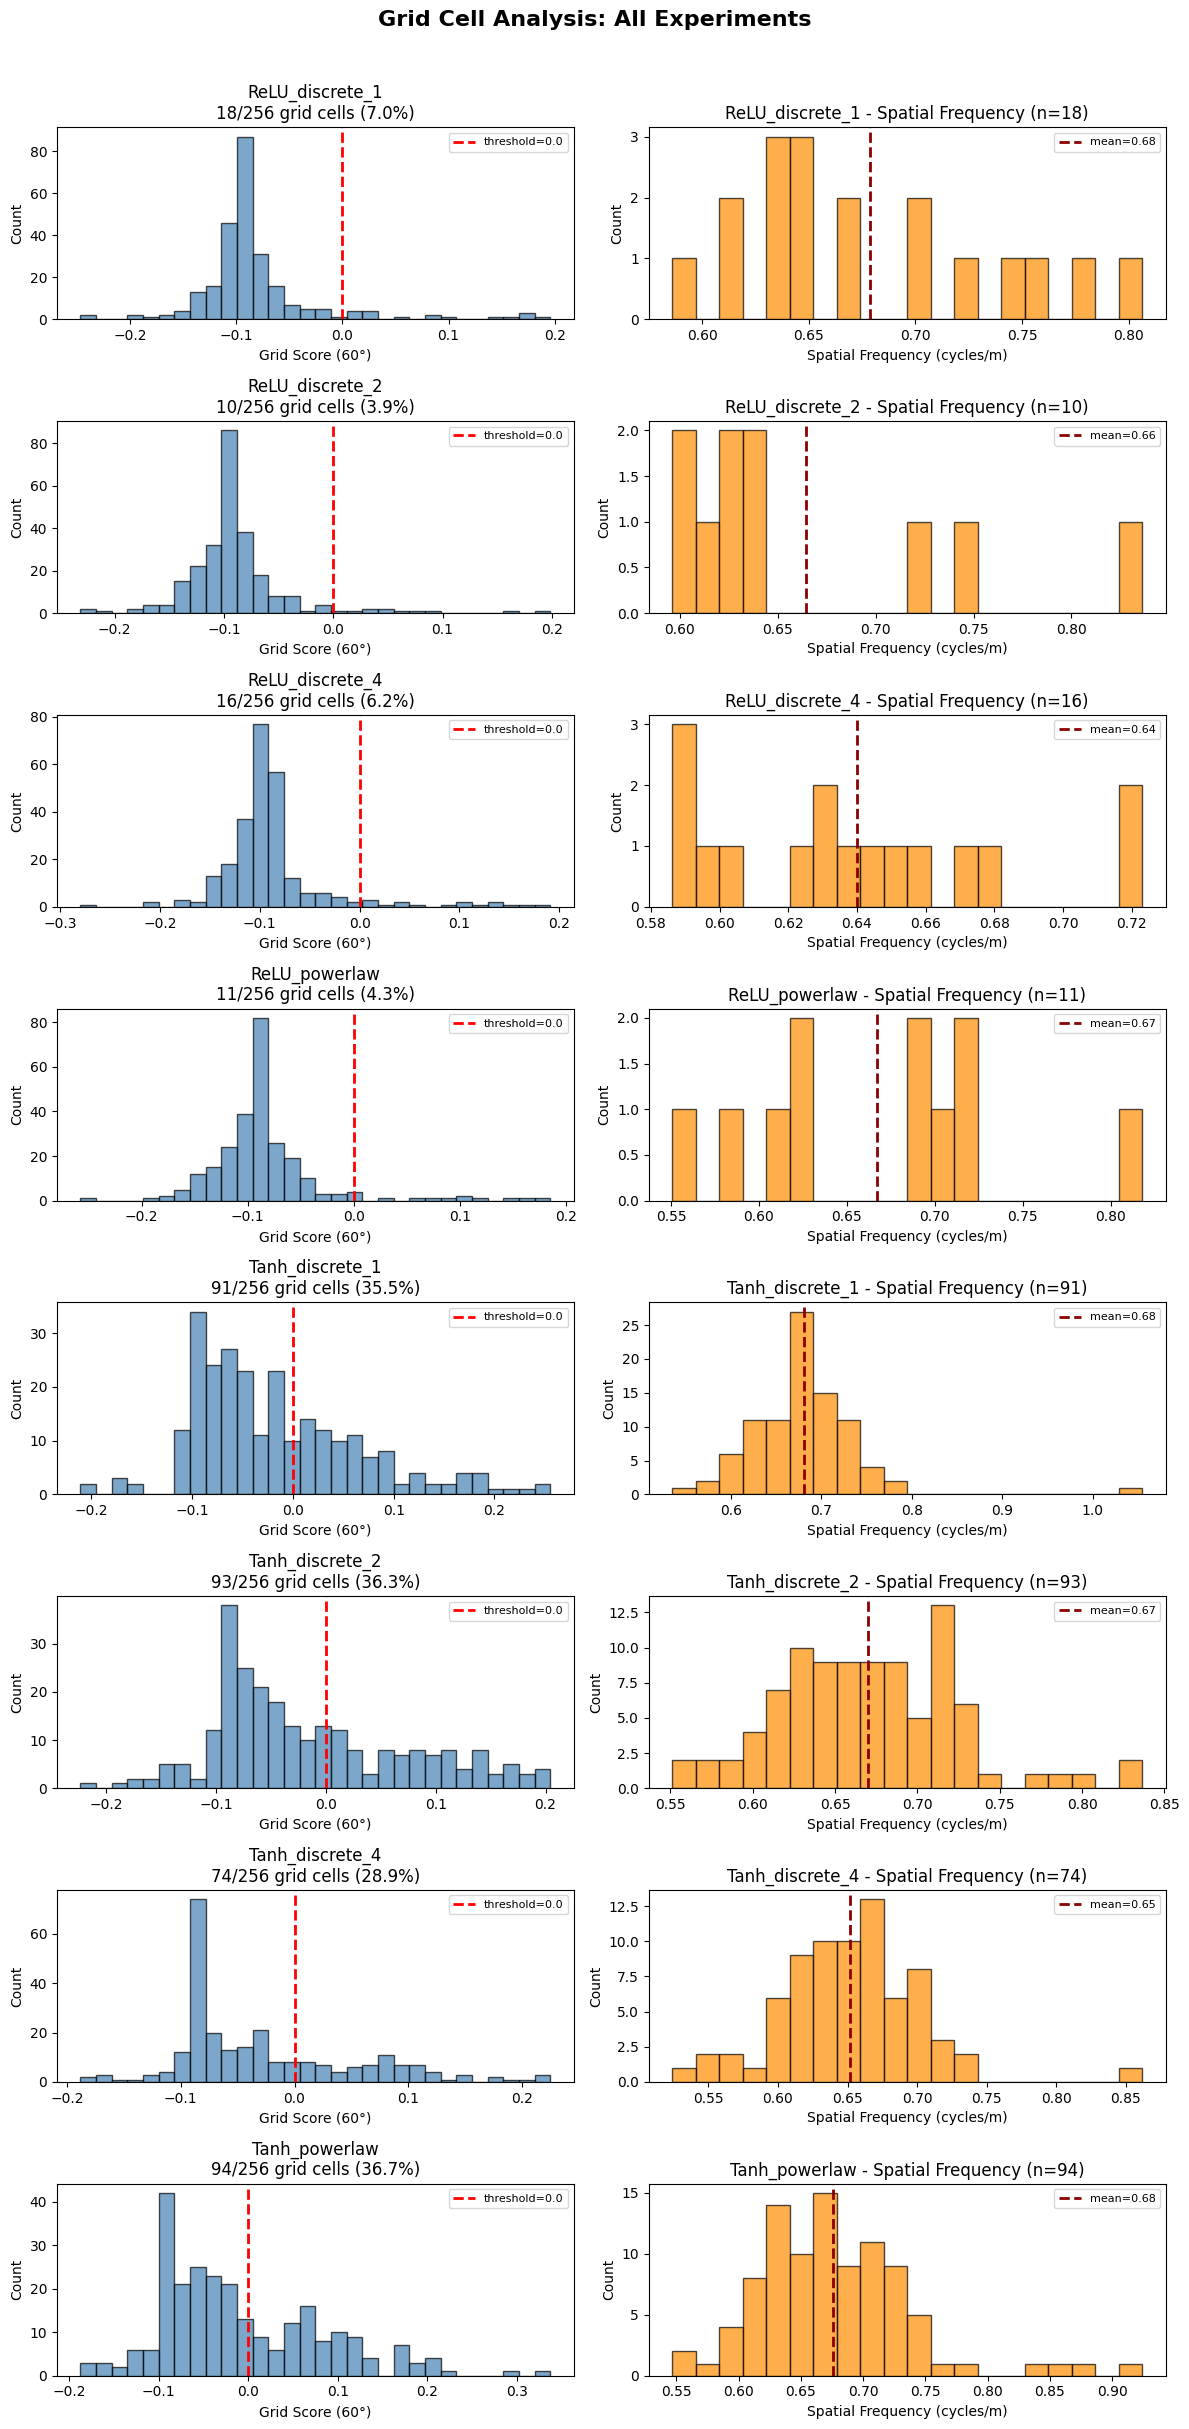

In [29]:
# Summary plot: Grid scores and spatial frequencies for all experiments
n_experiments = len(all_results)
if n_experiments > 0:
    fig, axes = plt.subplots(n_experiments, 2, figsize=(12, 3 * n_experiments))
    
    for row_idx, (exp_name, result) in enumerate(all_results.items()):
        # Grid score histogram
        plot_grid_score_histogram(
            scores=result["scores_60"],
            threshold=GRID_SCORE_THRESHOLD,
            ax=axes[row_idx, 0],
            title=exp_name,
        )
        
        # Spatial frequency histogram
        plot_spatial_frequency_histogram(
            freqs=result["spatial_frequencies"],
            scores=result["scores_60"],
            threshold=GRID_SCORE_THRESHOLD,
            ax=axes[row_idx, 1],
            title=f"{exp_name} - Spatial Frequency",
        )
    
    fig.suptitle("Grid Cell Analysis: All Experiments", fontsize=16, fontweight="bold", y=1.01)
    plt.tight_layout()
    plt.savefig(SWEEP_DIR / "summary_grid_scores_and_frequencies.png", dpi=150, bbox_inches="tight")
    plt.show()
else:
    print("No experiments loaded - check SWEEP_DIR path")

## Top Grid Cell Rate Maps

For each experiment, show the rate maps of the top 9 units by grid score.



ReLU_discrete_1


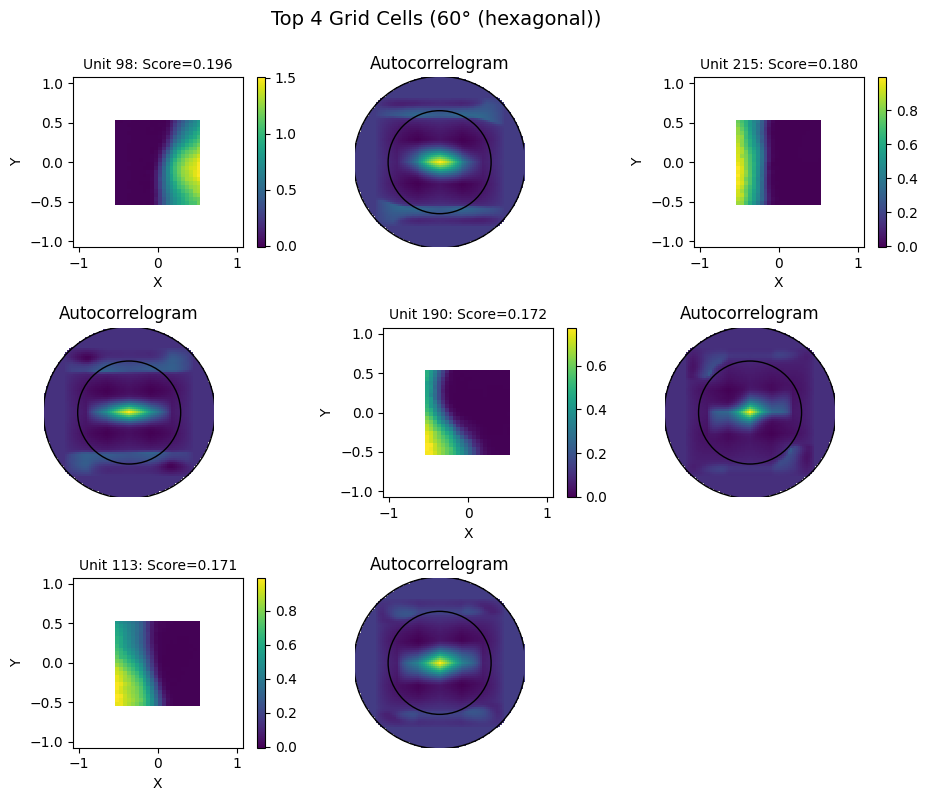


ReLU_discrete_2


<Figure size 640x480 with 0 Axes>

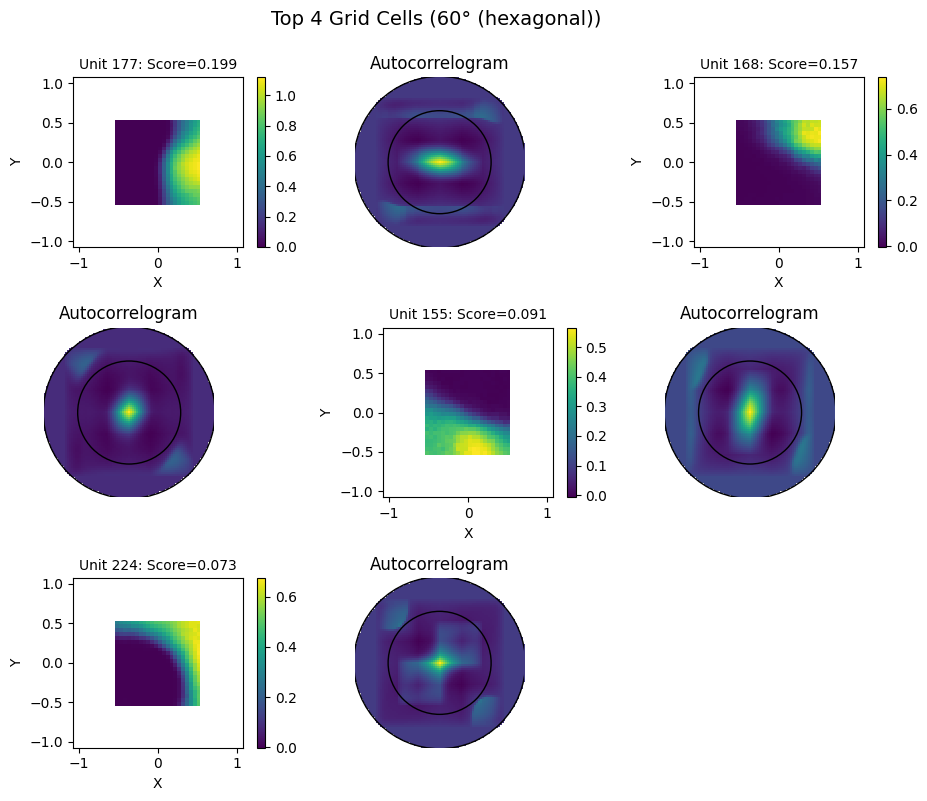


ReLU_discrete_4


<Figure size 640x480 with 0 Axes>

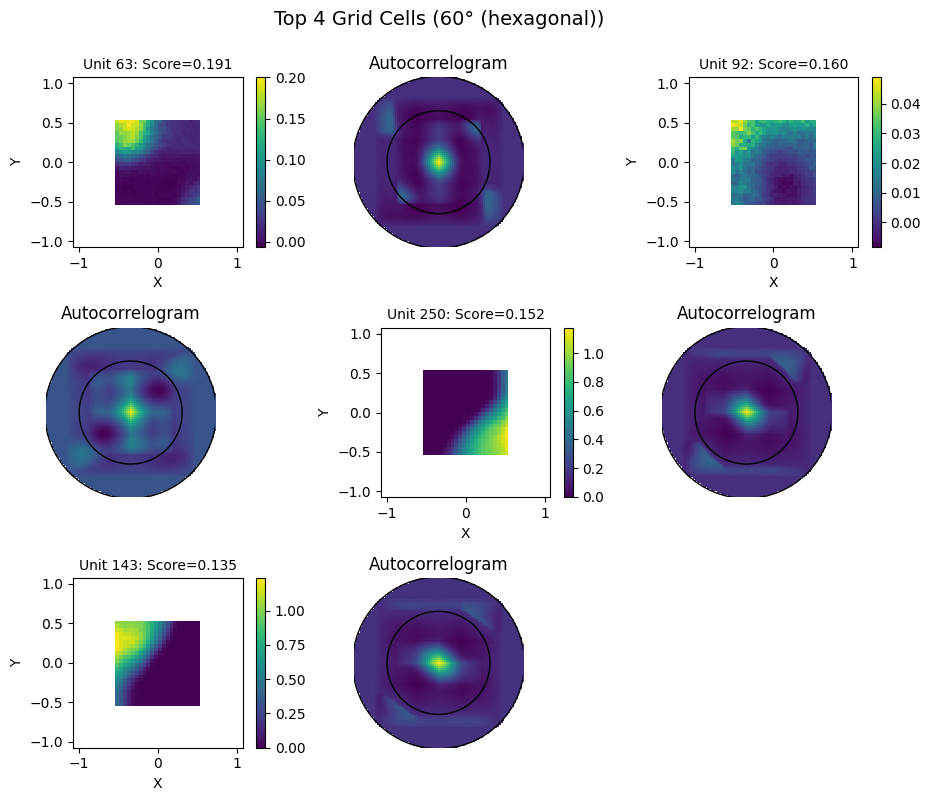


ReLU_powerlaw


<Figure size 640x480 with 0 Axes>

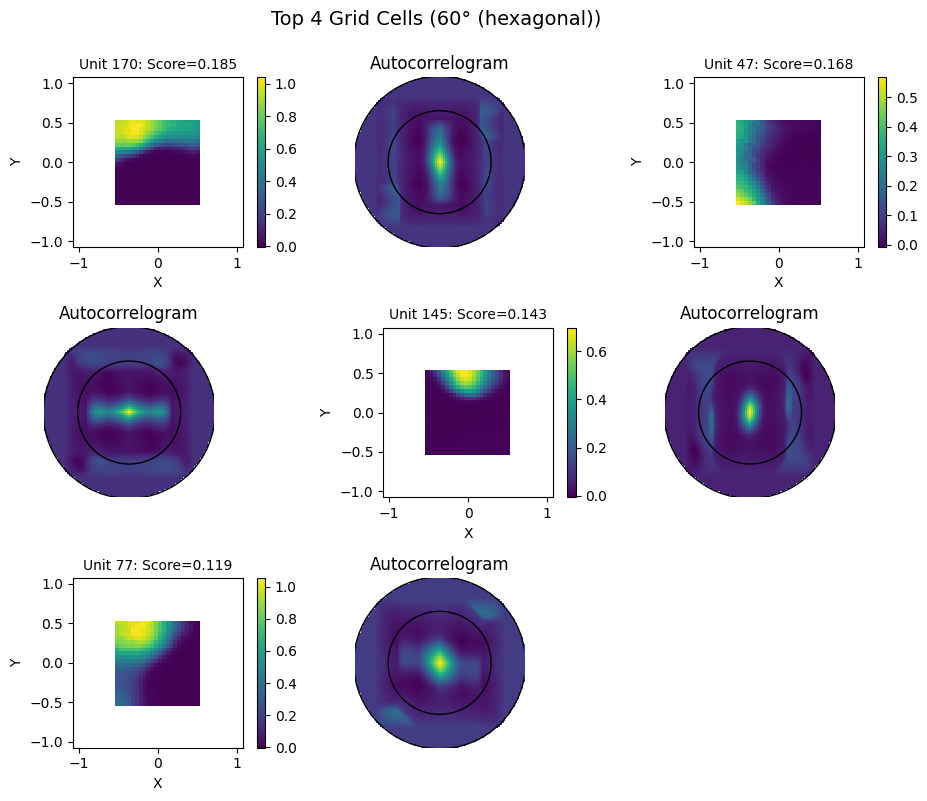


Tanh_discrete_1


<Figure size 640x480 with 0 Axes>

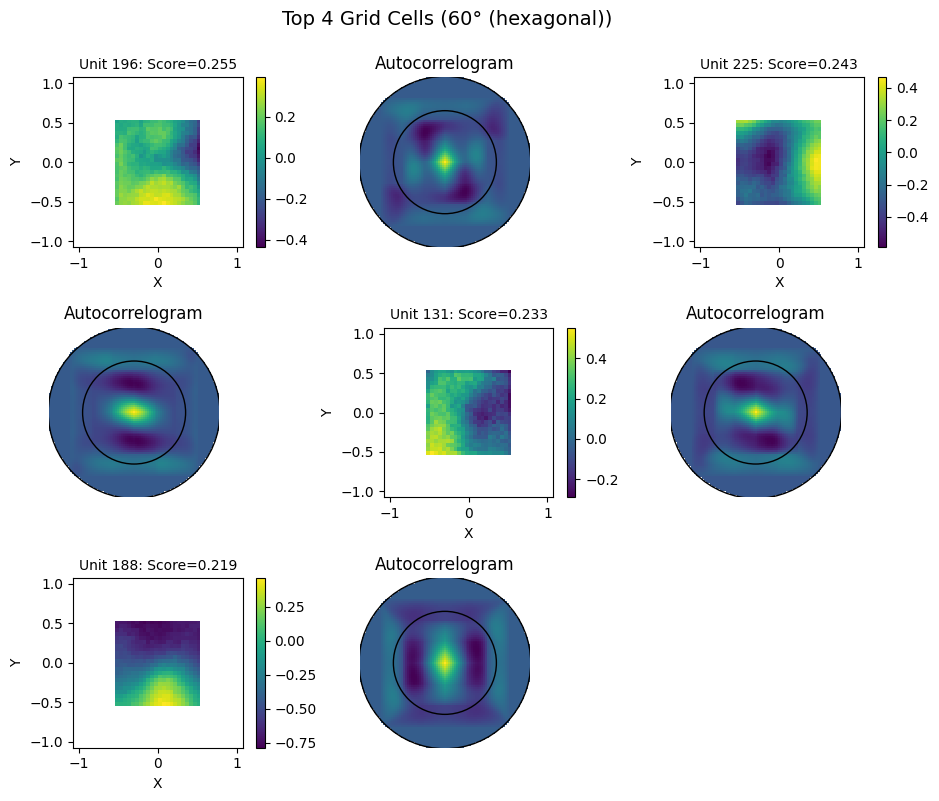


Tanh_discrete_2


<Figure size 640x480 with 0 Axes>

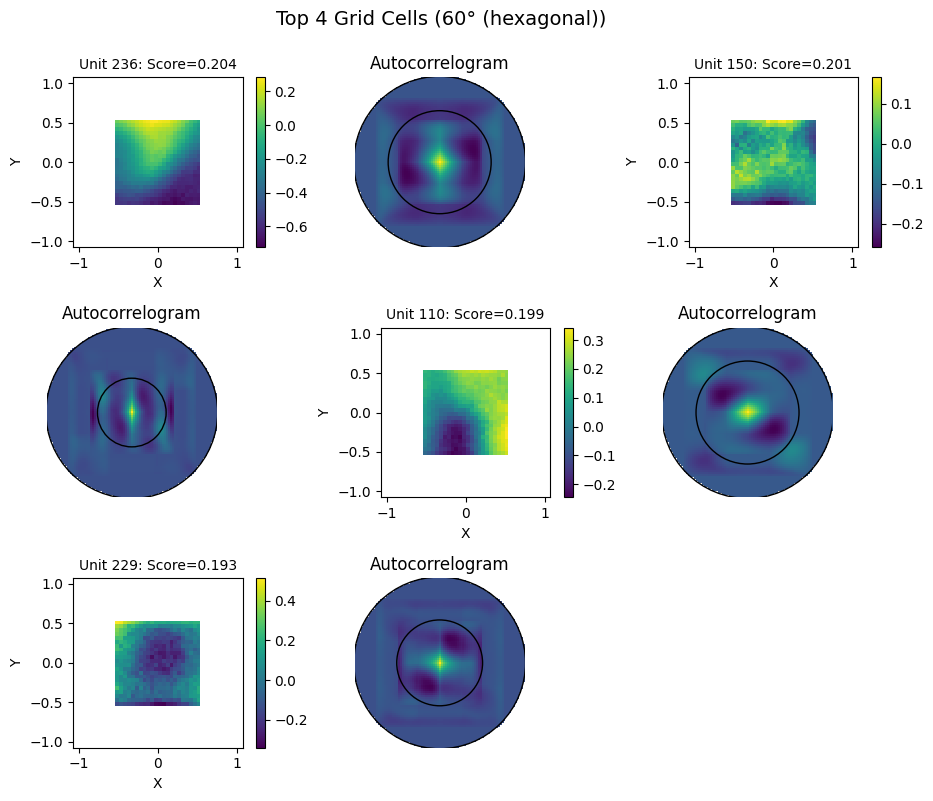


Tanh_discrete_4


<Figure size 640x480 with 0 Axes>

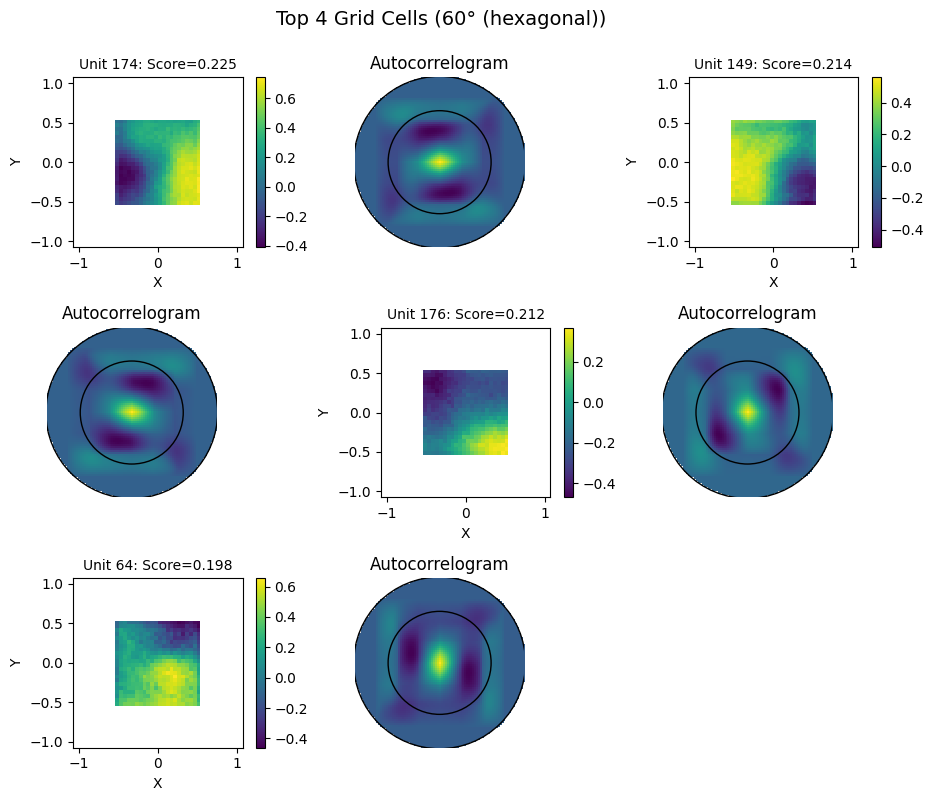


Tanh_powerlaw


<Figure size 640x480 with 0 Axes>

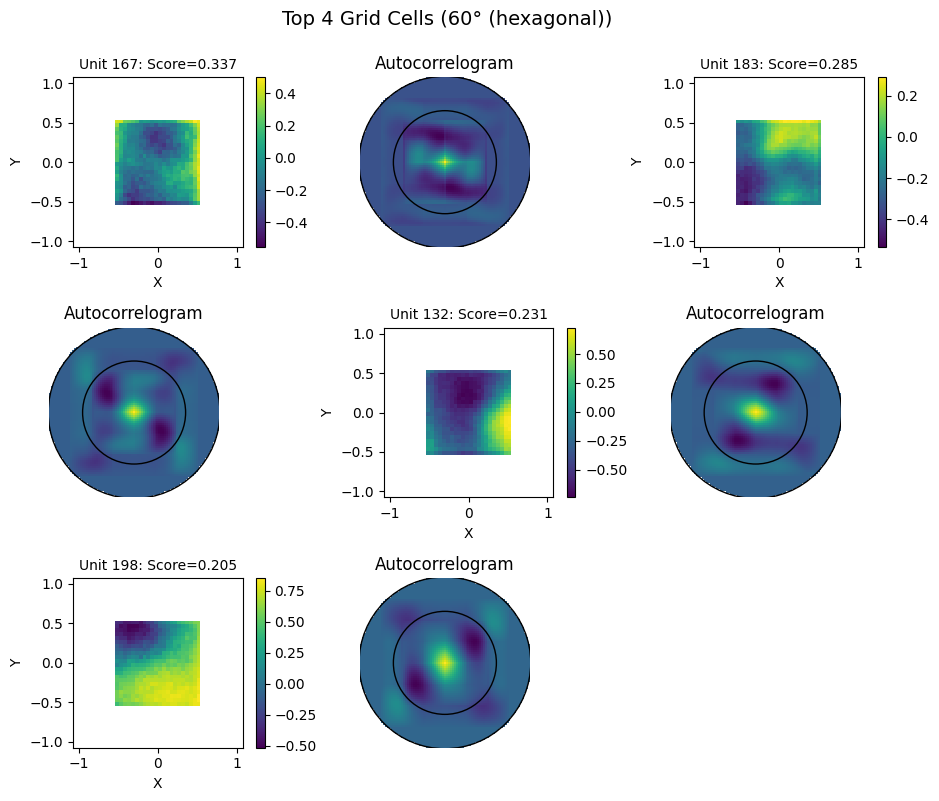

<Figure size 640x480 with 0 Axes>

In [30]:
# Plot top rate maps with SACs for each experiment using SpatialAnalyzer's built-in method
for exp_name, result in all_results.items():
    print(f"\n{'='*60}")
    print(f"{exp_name}")
    print('='*60)
    
    # Use the built-in plot_top_grid_cells method from SpatialAnalyzer
    spatial = result["spatial_analyzer"]
    spatial.plot_top_grid_cells(num_cells=4, score_type="60", figsize=(10, 8))
    
    # Save the current figure
    plt.savefig(SWEEP_DIR / f"{exp_name}_top_rate_maps.png", dpi=150, bbox_inches="tight")

## Summary Statistics


In [31]:
# Summary table
print("=" * 80)
print("SUMMARY: Grid Cell Statistics by Experiment")
print("=" * 80)
print(f"{'Experiment':<25} {'# Grid Cells':>12} {'% Grid':>10} {'Mean Freq':>12} {'Mean Spacing':>14}")
print("-" * 80)

for exp_name, result in all_results.items():
    scores = result["scores_60"]
    freqs = result["spatial_frequencies"]
    spacings = result["grid_spacings"]
    
    n_grid = np.sum(scores > GRID_SCORE_THRESHOLD)
    pct_grid = 100 * n_grid / len(scores)
    
    # Stats for grid cells only
    mask = scores > GRID_SCORE_THRESHOLD
    if np.sum(mask) > 0:
        grid_freqs = freqs[mask]
        grid_spacings = spacings[mask]
        valid_freqs = grid_freqs[~np.isnan(grid_freqs)]
        valid_spacings = grid_spacings[~np.isnan(grid_spacings)]
        
        mean_freq = np.mean(valid_freqs) if len(valid_freqs) > 0 else np.nan
        mean_spacing = np.mean(valid_spacings) if len(valid_spacings) > 0 else np.nan
    else:
        mean_freq = np.nan
        mean_spacing = np.nan
    
    freq_str = f"{mean_freq:.3f}" if not np.isnan(mean_freq) else "N/A"
    spacing_str = f"{mean_spacing:.3f} m" if not np.isnan(mean_spacing) else "N/A"
    
    print(f"{exp_name:<25} {n_grid:>12} {pct_grid:>9.1f}% {freq_str:>12} {spacing_str:>14}")

print("=" * 80)


SUMMARY: Grid Cell Statistics by Experiment
Experiment                # Grid Cells     % Grid    Mean Freq   Mean Spacing
--------------------------------------------------------------------------------
ReLU_discrete_1                     18       7.0%        0.679        1.484 m
ReLU_discrete_2                     10       3.9%        0.665        1.522 m
ReLU_discrete_4                     16       6.2%        0.640        1.569 m
ReLU_powerlaw                       11       4.3%        0.667        1.516 m
Tanh_discrete_1                     91      35.5%        0.681        1.479 m
Tanh_discrete_2                     93      36.3%        0.670        1.501 m
Tanh_discrete_4                     74      28.9%        0.652        1.542 m
Tanh_powerlaw                       94      36.7%        0.676        1.491 m


## Training Curves

Training and validation loss (log-log scale) and decoding error over epochs.

In [32]:
# Load training curves for all experiments
all_training_curves = {}
for exp_name in EXPERIMENT_NAMES:
    try:
        all_training_curves[exp_name] = load_training_curves(SWEEP_DIR, exp_name)
    except FileNotFoundError as e:
        print(f"Skipping {exp_name}: {e}")

print(f"Loaded training curves for {len(all_training_curves)} experiments")

Loaded training curves for 8 experiments


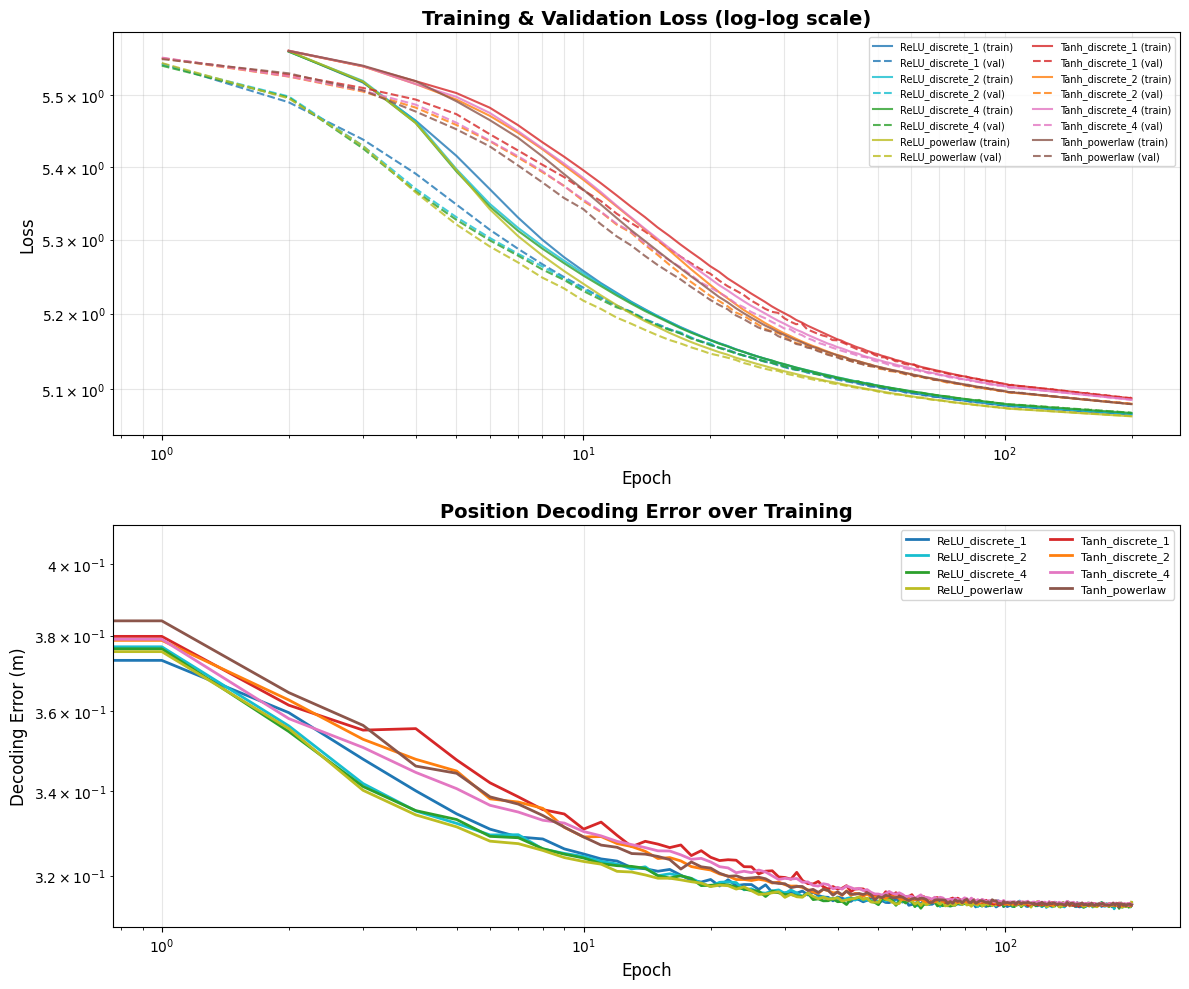

In [33]:
# Plot training/validation loss and decoding error
fig, axes = plt.subplots(2, 1, figsize=(12, 10))

# Color schemes for ReLU vs Tanh
colors = {
    "ReLU_discrete_1": "tab:blue",
    "ReLU_discrete_2": "tab:cyan",
    "ReLU_discrete_4": "tab:green",
    "ReLU_powerlaw": "tab:olive",
    "Tanh_discrete_1": "tab:red",
    "Tanh_discrete_2": "tab:orange",
    "Tanh_discrete_4": "tab:pink",
    "Tanh_powerlaw": "tab:brown",
}

# --- Top: Train/Val Loss (log-log) ---
ax = axes[0]
for exp_name, curves in all_training_curves.items():
    epochs = curves["epochs"] + 1  # Shift for log scale (avoid log(0))
    color = colors.get(exp_name, "gray")
    
    ax.plot(epochs[1:], curves["train_loss"], color=color, linestyle="-", linewidth=1.5, 
            label=f"{exp_name} (train)", alpha=0.8)
    ax.plot(epochs, curves["val_loss"], color=color, linestyle="--", linewidth=1.5, 
            label=f"{exp_name} (val)", alpha=0.8)

ax.set_xscale("log")
ax.set_yscale("log")
ax.set_xlabel("Epoch", fontsize=12)
ax.set_ylabel("Loss", fontsize=12)
ax.set_title("Training & Validation Loss (log-log scale)", fontsize=14, fontweight="bold")
ax.legend(loc="upper right", fontsize=7, ncol=2)
ax.grid(True, alpha=0.3, which="both")

# --- Bottom: Decoding Error ---
ax = axes[1]
for exp_name, curves in all_training_curves.items():
    epochs = curves["epochs"]
    color = colors.get(exp_name, "gray")
    
    ax.plot(epochs, curves["decoding_error"], color=color, linewidth=2, label=exp_name)
    ax.set_xscale("log")
    ax.set_yscale("log")

ax.set_xlabel("Epoch", fontsize=12)
ax.set_ylabel("Decoding Error (m)", fontsize=12)
ax.set_title("Position Decoding Error over Training", fontsize=14, fontweight="bold")
ax.legend(loc="upper right", fontsize=8, ncol=2)
ax.grid(True, alpha=0.3)

plt.tight_layout()
plt.savefig(SWEEP_DIR / "training_curves.png", dpi=150, bbox_inches="tight")
plt.show()

## OOD Generalization Analysis

Test model performance on out-of-distribution conditions:
1. Trajectory length (longer than training)
2. Behavioral timescale mean
3. Behavioral timescale std


In [34]:
# OOD test parameters
test_lengths = [10, 20, 30, 50, 75, 100, 150, 200]
test_behav_means = [0.3, 0.4, 0.5, 0.6, 0.7, 0.8, 0.9, 1.0, 1.2, 1.5]
test_behav_stds = [0.0, 0.05, 0.1, 0.15, 0.2, 0.3, 0.4, 0.5]

# Load training config to get reference values
sample_config_path = SWEEP_DIR / EXPERIMENT_NAMES[0] / "seed_0" / "config_seed0.yaml"
with open(sample_config_path) as f:
    sample_config = yaml.safe_load(f)

training_length = sample_config["num_time_steps"]
training_behav_mean = sample_config["behavioral_timescale_mean"]
training_behav_std = sample_config["behavioral_timescale_std"]

print(f"Training length: {training_length} steps")
print(f"Training behavioral timescale: mean={training_behav_mean}s, std={training_behav_std}s")

Training length: 50 steps
Training behavioral timescale: mean=0.6s, std=0.0s


In [35]:
def evaluate_ood(
    model: MultiTimescaleRNN,
    config: dict,
    place_cell_centers: torch.Tensor,
    test_type: str,
    test_values: list,
    num_trajectories: int = 100,
    device: str = "cuda",
) -> np.ndarray:
    """
    Evaluate model on out-of-distribution conditions.
    
    Args:
        model: Trained model
        config: Training config
        place_cell_centers: Place cell centers used during training
        test_type: "length", "behav_mean", or "behav_std"
        test_values: List of test values
        num_trajectories: Number of test trajectories
        device: Device to run on
        
    Returns:
        Array of decoding errors for each test value
    """
    errors = []
    model.eval()
    
    for val in test_values:
        # Create test config
        test_config = config.copy()
        test_config["num_trajectories"] = num_trajectories
        test_config["batch_size"] = min(64, num_trajectories)
        test_config["train_val_split"] = 0.0
        
        if test_type == "length":
            test_config["num_time_steps"] = val
        elif test_type == "behav_mean":
            test_config["behavioral_timescale_mean"] = val
        elif test_type == "behav_std":
            test_config["behavioral_timescale_std"] = val
        
        # Create datamodule
        dm = PathIntegrationDataModule(
            trajectory_type=test_config["trajectory_type"],
            velocity_representation=test_config["velocity_representation"],
            dt=test_config["dt"],
            num_time_steps=test_config["num_time_steps"],
            arena_size=test_config["arena_size"],
            num_place_cells=test_config["num_place_cells"],
            place_cell_rf=test_config["place_cell_rf"],
            DoG=test_config["DoG"],
            surround_scale=test_config["surround_scale"],
            place_cell_layout=test_config["place_cell_layout"],
            behavioral_timescale_mean=test_config["behavioral_timescale_mean"],
            behavioral_timescale_std=test_config["behavioral_timescale_std"],
            linear_speed_tau=test_config.get("linear_speed_tau", 1.0),
            angular_speed_mean=test_config.get("angular_speed_mean", 0.0),
            angular_speed_std=test_config.get("angular_speed_std", 1.0),
            angular_speed_tau=test_config.get("angular_speed_tau", 0.4),
            num_trajectories=num_trajectories,
            batch_size=test_config["batch_size"],
            num_workers=4,
            train_val_split=0.0,
        )
        dm.place_cell_centers = place_cell_centers
        dm.setup()
        
        # Evaluate
        all_errors = []
        with torch.no_grad():
            for batch in dm.val_dataloader():
                inputs, positions, targets = batch
                inputs = inputs.to(device)
                targets = targets.to(device)
                
                _, outputs = model(inputs, targets[:, 0, :])
                
                # Decode position from output (argmax over place cells)
                pred_probs = torch.softmax(outputs, dim=-1)
                pred_idx = pred_probs.argmax(dim=-1)  # (batch, time)
                
                # Get predicted positions
                pc_centers = place_cell_centers.to(device)
                pred_positions = pc_centers[pred_idx]  # (batch, time, 2)
                
                # Compute error
                error = torch.sqrt(((positions.to(device) - pred_positions) ** 2).sum(-1))
                all_errors.append(error.mean().item())
        
        errors.append(np.mean(all_errors))
    
    return np.array(errors)

In [36]:
# Run OOD evaluation for all experiments
all_ood_results = {}

for exp_name in EXPERIMENT_NAMES:
    print(f"\n{'='*60}")
    print(f"OOD Evaluation: {exp_name}")
    print('='*60)
    
    exp_path = SWEEP_DIR / exp_name / "seed_0"
    
    try:
        # Load config
        with open(exp_path / "config_seed0.yaml") as f:
            config = yaml.safe_load(f)
        
        # Load model
        ts_config = config.get("timescales_config", {})
        activation_cls = getattr(nn, config.get("activation", "ReLU"))
        
        model = MultiTimescaleRNN(
            input_size=config["input_size"],
            hidden_size=config["hidden_size"],
            output_size=config["num_place_cells"],
            dt=config["dt"],
            timescales_config=ts_config,
            activation=activation_cls,
            learn_timescales=config.get("learn_timescales", False),
            zero_diag_wrec=config.get("zero_diag_wrec", True),
        )
        model.load_state_dict(torch.load(exp_path / "final_model_seed0.pth", map_location=device))
        model.to(device)
        model.eval()
        
        # Load place cell centers
        place_cell_centers = torch.load(exp_path / "place_cell_centers_seed0.pt", map_location=device)
        
        # Run OOD tests
        print("  Testing trajectory lengths...")
        length_errors = evaluate_ood(model, config, place_cell_centers, "length", test_lengths, device=device)
        
        print("  Testing behavioral timescale means...")
        behav_mean_errors = evaluate_ood(model, config, place_cell_centers, "behav_mean", test_behav_means, device=device)
        
        print("  Testing behavioral timescale stds...")
        behav_std_errors = evaluate_ood(model, config, place_cell_centers, "behav_std", test_behav_stds, device=device)
        
        all_ood_results[exp_name] = {
            "length": length_errors,
            "behav_mean": behav_mean_errors,
            "behav_std": behav_std_errors,
        }
        
        print(f"  Done!")
        
    except Exception as e:
        print(f"  ERROR: {e}")

print(f"\n{'='*60}")
print(f"OOD evaluation complete for {len(all_ood_results)} experiments")
print('='*60)


OOD Evaluation: ReLU_discrete_1
  Testing trajectory lengths...
Behavioral timescale parameterization:
  τ_behavior: mean=0.600s, std=0.000s
  → linear_speed: mean=0.333m/s, std=0.000m/s
Behavioral timescale parameterization:
  τ_behavior: mean=0.600s, std=0.000s
  → linear_speed: mean=0.333m/s, std=0.000m/s


Behavioral timescale parameterization:
  τ_behavior: mean=0.600s, std=0.000s
  → linear_speed: mean=0.333m/s, std=0.000m/s
Behavioral timescale parameterization:
  τ_behavior: mean=0.600s, std=0.000s
  → linear_speed: mean=0.333m/s, std=0.000m/s
Behavioral timescale parameterization:
  τ_behavior: mean=0.600s, std=0.000s
  → linear_speed: mean=0.333m/s, std=0.000m/s
Behavioral timescale parameterization:
  τ_behavior: mean=0.600s, std=0.000s
  → linear_speed: mean=0.333m/s, std=0.000m/s
Behavioral timescale parameterization:
  τ_behavior: mean=0.600s, std=0.000s
  → linear_speed: mean=0.333m/s, std=0.000m/s
Behavioral timescale parameterization:
  τ_behavior: mean=0.600s, std=0.000s
  → linear_speed: mean=0.333m/s, std=0.000m/s
  Testing behavioral timescale means...
Behavioral timescale parameterization:
  τ_behavior: mean=0.300s, std=0.000s
  → linear_speed: mean=0.667m/s, std=0.000m/s
Behavioral timescale parameterization:
  τ_behavior: mean=0.400s, std=0.000s
  → linear_speed: mean

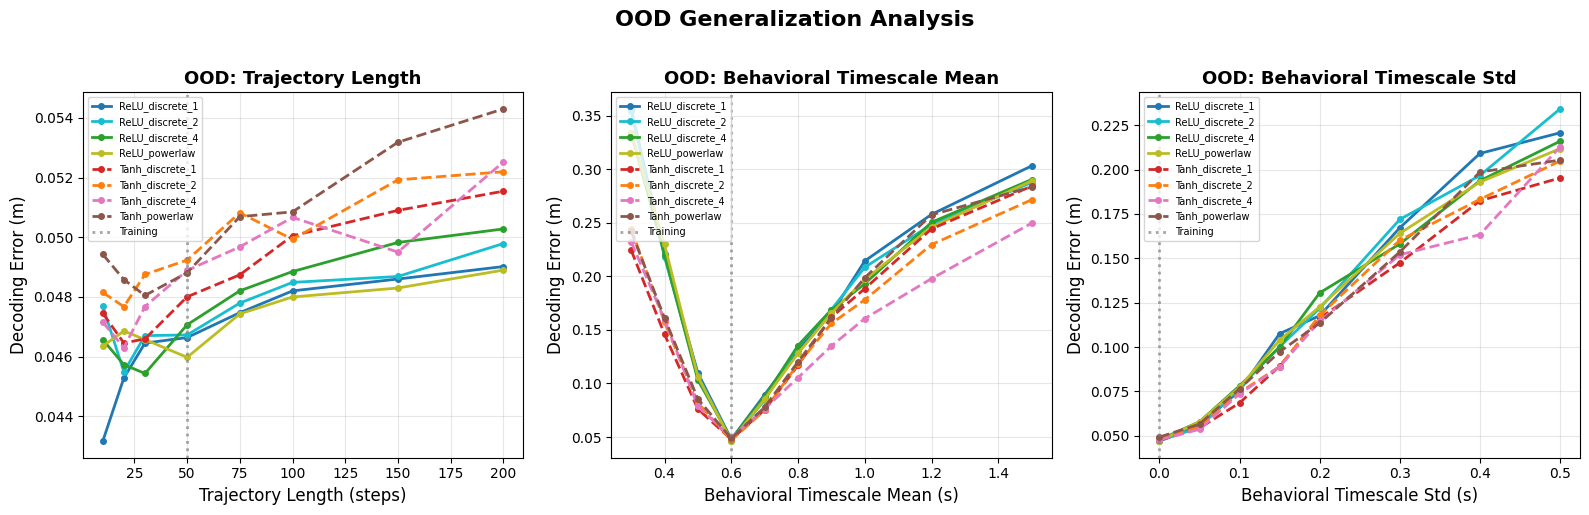

In [37]:
# Plot OOD generalization results
fig, axes = plt.subplots(1, 3, figsize=(16, 5))

# Linestyles: solid for ReLU, dashed for Tanh
linestyles = {name: "-" if "ReLU" in name else "--" for name in EXPERIMENT_NAMES}

# --- 1: Trajectory Length ---
ax = axes[0]
for exp_name, results in all_ood_results.items():
    color = colors.get(exp_name, "gray")
    ls = linestyles.get(exp_name, "-")
    ax.plot(test_lengths, results["length"], color=color, linestyle=ls, linewidth=2, 
            label=exp_name, marker="o", markersize=4)

ax.axvline(training_length, color="gray", linestyle=":", linewidth=2, alpha=0.7, label="Training")
ax.set_xlabel("Trajectory Length (steps)", fontsize=12)
ax.set_ylabel("Decoding Error (m)", fontsize=12)
ax.set_title("OOD: Trajectory Length", fontsize=13, fontweight="bold")
ax.legend(loc="upper left", fontsize=7)
ax.grid(True, alpha=0.3)

# --- 2: Behavioral Timescale Mean ---
ax = axes[1]
for exp_name, results in all_ood_results.items():
    color = colors.get(exp_name, "gray")
    ls = linestyles.get(exp_name, "-")
    ax.plot(test_behav_means, results["behav_mean"], color=color, linestyle=ls, linewidth=2, 
            label=exp_name, marker="o", markersize=4)

ax.axvline(training_behav_mean, color="gray", linestyle=":", linewidth=2, alpha=0.7, label="Training")
ax.set_xlabel("Behavioral Timescale Mean (s)", fontsize=12)
ax.set_ylabel("Decoding Error (m)", fontsize=12)
#ax.set_yscale("log")
ax.set_title("OOD: Behavioral Timescale Mean", fontsize=13, fontweight="bold")
ax.legend(loc="upper left", fontsize=7)
ax.grid(True, alpha=0.3)

# --- 3: Behavioral Timescale Std ---
ax = axes[2]
for exp_name, results in all_ood_results.items():
    color = colors.get(exp_name, "gray")
    ls = linestyles.get(exp_name, "-")
    ax.plot(test_behav_stds, results["behav_std"], color=color, linestyle=ls, linewidth=2, 
            label=exp_name, marker="o", markersize=4)

ax.axvline(training_behav_std, color="gray", linestyle=":", linewidth=2, alpha=0.7, label="Training")
ax.set_xlabel("Behavioral Timescale Std (s)", fontsize=12)
ax.set_ylabel("Decoding Error (m)", fontsize=12)
ax.set_title("OOD: Behavioral Timescale Std", fontsize=13, fontweight="bold")
ax.legend(loc="upper left", fontsize=7)
ax.grid(True, alpha=0.3)

fig.suptitle("OOD Generalization Analysis", fontsize=16, fontweight="bold", y=1.02)
plt.tight_layout()
plt.savefig(SWEEP_DIR / "ood_generalization.png", dpi=150, bbox_inches="tight")
plt.show()